### Day 3 - RGB blur

In [ ]:
import numpy as np
from PIL import Image

In [ ]:
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
cuda.init()

device = cuda.Device(0)

print(f"Cuda version: {".".join([str(i) for i in cuda.get_version()])}")
print(f"Device:\t{device.name()}")

Cuda version: 12.8.0
Device:	NVIDIA GeForce RTX 3080 Laptop GPU


In [ ]:
from pathlib import Path

[day_03_blurry.cu](https://github.com/xl0/cuda-100/blob/master/nbs/day_04_matmaul.cu)

In [ ]:
#|output: asis
#|echo: false

c_code = Path('day_04_matmul.cu').read_text()
print(f'''
::: {{.code-block}}
```
{c_code}
```
:::
''')


::: {.code-block}
```
#include <stdint.h>
#include <stdio.h>

__global__ void matmul_f32(float *m1, float *m2, float *res,
    uint32_t out_shape_0,
    uint32_t out_shape_1,
    uint32_t inner_dim,
    uint32_t ) {

    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    int m1_width = inner_dim;
    int m2_width = out_shape_1;

    double out;
    if (x < out_shape_1 && y < out_shape_0) {
        out = 0;
        for (int i = 0; i < inner_dim; i++) {
            out += m1[y*m1_width + i] * m2[i*m2_width + x];
        }
        res[y*out_shape_1 + x] = out;
    }



    // if (x < w && y < h) {
    //     int idx = (y * w + x);

    //     for (int ch = 0; ch < 3; ch++) {
    //         uint32_t v = 0;
    //         for (int j = -blur; j <= (int)blur; j++) {
    //             for (int i = -blur; i <= (int)blur; i++) {
    //                 if (y + j >= 0   &&
    //                     y + j < h    &&
    //                     x 

In [ ]:
from lovely_numpy import Lo

In [ ]:
m1 = np.random.randn(100, 200).astype(np.float32)
m2 = np.random.randn(200, 300).astype(np.float32)

np_res = np.matmul(m1, m2)
Lo(np_res)

array[100, 300] f32 n=30000 (0.1Mb) x∈[-81.072, 54.578] μ=-0.081 σ=14.183

In [ ]:
BLOCK_SIZE_X = 32
BLOCK_SIZE_Y = 32

assert(len(m1.shape) == 2)
assert(len(m2.shape) == 2)
assert(m1.shape[1] == m2.shape[0])

out_shape = (m1.shape[0], m2.shape[1])

try:
    ctx = device.make_context()

    mod = SourceModule(Path("day_04_matmul.cu").read_text(),
        options=[
            '-Xcompiler', '-Wall',
            '-Xcompiler', '-Wextra',
            '-Xcompiler', '-Wsign-conversion',
            '-Xcompiler', '-Wcast-qual',
            '-Xcompiler', '-Wunused-parameter',
            '-Xcompiler', '-Wdouble-promotion',
            '-Xcompiler', '-Wformat=2',
            '-Xcompiler', '-Wfloat-equal',
            '-Xcompiler', '-Wshadow'
        ]
        )

    matmul_f32 = mod.get_function("matmul_f32")

    gpu_m1 = cuda.mem_alloc_like(m1)
    gpu_m2 = cuda.mem_alloc_like(m2)

    res = np.empty(out_shape, dtype=np.float32)

    gpu_res = cuda.mem_alloc_like(res)


    cuda.memcpy_htod(gpu_m1, m1)
    cuda.memcpy_htod(gpu_m2, m2)

    block_size = (BLOCK_SIZE_X, BLOCK_SIZE_Y, 1)
    grid_size = (
        ((out_shape[1] + BLOCK_SIZE_X - 1) // BLOCK_SIZE_X),
        ((out_shape[0] + BLOCK_SIZE_Y - 1) // BLOCK_SIZE_Y),
        1
    )

    print(f"Grid size: {grid_size}")
    print(f"Block size: {block_size}")
    print(f"Restul dimensions: {out_shape[0]}x{out_shape[1]}")
    print(f"Total threads: {grid_size[0] * grid_size[1] * block_size[0] * block_size[1]}")

    ctx.synchronize()

    matmul_f32(gpu_m1, gpu_m2, gpu_res, np.uint32(out_shape[0]), np.uint32(out_shape[1]), np.uint32(m1.shape[1]), grid=grid_size, block=block_size)

    ctx.synchronize()

    cuda.memcpy_dtoh(res, gpu_res)
    ctx.synchronize()


finally:
    ctx.pop()
    ctx.detach()

Lo(res)

Grid size: (10, 4, 1)
Block size: (32, 32, 1)
Restul dimensions: 100x300
Total threads: 40960


array[100, 300] f32 n=30000 (0.1Mb) x∈[-81.073, 54.578] μ=-0.081 σ=14.183

In [ ]:
m1[0,1],m2[1,0]

(np.float32(-1.1215224), np.float32(-0.32335585))

In [ ]:
np.isclose(res, np_res).all()

np.False_

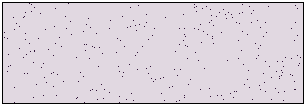

In [ ]:
Lo(np.isclose(res, np_res)).chans

### Looks like matmul is very succeptible to numerical instability.
> Since we are adding numbers to the accumulator over and over, if it accumulated value gets large enough,
> it will lose precision to correctly accumulate small values. If it then gets a large negative update and becomes
> small again, those errors will become significant.